In [24]:
svc = LinearSVC(featuresCol=idf.getOutputCol(), labelCol='class')
svcModel = svc.fit(ptrainDF)
predictionsSVC = svcModel.transform(ptestDF)
evaluator.evaluate(predictionsSVC)


In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import string
from pyspark import sql
from pyspark.sql.session import SparkSession
from pyspark.context import SparkContext
from pyspark import SparkConf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import Word2Vec, Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [2]:
JSON_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler.json.gz'
TOKENIZED_CSV_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler_tokenized.json'
DF_CSV_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler_processed.csv'
DEBUG_CHECKPOINT_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/SparkCheckpoint'


In [3]:
sparkConf = SparkConf().setAppName('CMPE256')
sparkConf.set('spark.executor.memory', '16g')
sparkConf.set('spark.executor.cores', '5')
sparkConf.set('spark.cores.max', '40')
sparkConf.set('spark.driver.memory', '12g')
sparkConf.set('spark.driver.maxResultSize', '4g')

spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
spark.sparkContext.setCheckpointDir(DEBUG_CHECKPOINT_PATH)


In [4]:
dataSetRaw = spark.read.json(JSON_PATH)
dataSetRaw.show(25)


+--------+-----------+------+--------------------+--------------------+----------+--------------------+
| book_id|has_spoiler|rating|           review_id|    review_sentences| timestamp|             user_id|
+--------+-----------+------+--------------------+--------------------+----------+--------------------+
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|
|   16981|      false|     3|a5d2c3628987712d0...|[[0, Recommended ...|2017-03-22|8842281e1d1347389...|
|28684704|       true|     3|2ede853b14dc4583f...|[[0, A fun, fast ...|2017-03-20|8842281e1d1347389...|
|27161156|      false|     0|ced5675e55cd9d38a...|[[0, Recommended ...|2016-11-09|8842281e1d1347389...|
|25884323|       true|     4|33273272586313127...|[[0, I really enj...|2016-04-25|8842281e1d1347389...|
|19398490|      false|     4|ea4a220b10e6b5c79...|[[0, A beautiful ...|2016-09-20|8842281e1d1347389...|
|22318578|      false|     5|5fe9882bfe4b0520a...|[[0, 5 stars f

In [5]:
dataSet = dataSetRaw.withColumn('reviewNew', F.explode('review_sentences'))
dataSet.show()


+--------+-----------+------+--------------------+--------------------+----------+--------------------+--------------------+
| book_id|has_spoiler|rating|           review_id|    review_sentences| timestamp|             user_id|           reviewNew|
+--------+-----------+------+--------------------+--------------------+----------+--------------------+--------------------+
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, This is a spe...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, It started sl...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, This is what ...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, It is a 2015 ...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, For instance ...|


In [6]:
columns = ['book_id', 'user_id', 'review_id', 'has_spoiler', 'rating'] + [dataSet.reviewNew[i] for i in range(2)]
dataSet = dataSet.select(columns).withColumnRenamed('reviewNew[0]', 'class').withColumnRenamed('reviewNew[1]', 'reviews')
dataSet.show(15)


+--------+--------------------+--------------------+-----------+------+-----+--------------------+
| book_id|             user_id|           review_id|has_spoiler|rating|class|             reviews|
+--------+--------------------+--------------------+-----------+------+-----+--------------------+
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|This is a special...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It started slow f...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|This is what I lo...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It is a 2015 Hugo...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|For instance the ...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It is a book abou...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|The science descr...|
|18245960|

In [7]:
processedDF = dataSet.groupBy('review_id', 'class').agg(F.concat_ws(' ', F.collect_list('reviews')).alias('review'))
processedDF.show()


+--------------------+-----+--------------------+
|           review_id|class|              review|
+--------------------+-----+--------------------+
|000308f567300ad18...|    0|ugly tears! i tho...|
|000d24842598aeb46...|    0|Wow! I remember t...|
|000d2f3370e5be5d2...|    0|Shiver was a whol...|
|00154dc730c8e307e...|    0|Actual rating: 2....|
|002039bae02d68829...|    0|Issues I had: 1) ...|
|0027981f92f14babc...|    0|"A ribbon so you ...|
|00368800412e4550d...|    0|BEST STEPHENIE ME...|
|003b6c962339c876a...|    0|This book was eve...|
|004ca6a8cf2e95059...|    0|SPOILER FREE I wa...|
|0056da1ce5f6c85d0...|    0|I enjoyed the boo...|
|00626d89a4e146f99...|    0|It was a really w...|
|0064778ea161a0c3c...|    0|Genetically engin...|
|0069f7e0abbcd6bc6...|    0|Actual Rating: 3....|
|006bdea4755ac39aa...|    0|It can bring tear...|
|006c58c1070fa0a27...|    0|This review can a...|
|006e6d9b974a89537...|    0|Lively and entert...|
|006e7a2df93735249...|    1|I have mixed feel...|


In [8]:
dataSet = processedDF.join(dataSetRaw, on='review_id', how='left')
dataSet.show()


+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+
|           review_id|class|              review| book_id|has_spoiler|rating|    review_sentences| timestamp|             user_id|
+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+
|0008423c9faf30b79...|    0|This is a paranor...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|
|0008423c9faf30b79...|    1|The explaination ...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|
|0009afd5f2f92cf41...|    0|This was a fluffy...|  690067|      false|     3|[[0, This was a f...|2014-01-17|07d45e70fdee94889...|
|000ba52e8a75a1aae...|    0|What a beautiful ...|13639050|      false|     5|[[0, What a beaut...|2012-10-20|1b999330991ea0630...|
|001384a17d9d6b7a0...|    0|Wow. I rarely lov...|31567731|      false|     5|[[0, W

In [9]:
dataSet = dataSet.select('review_id', 'class', 'review', 'user_id', 'book_id', 'timestamp', 'rating')


In [10]:
count = dataSet.groupBy('class').count().collect()
count


[Row(class='0', count=1377268), Row(class='1', count=89627)]

In [13]:
neutralCount, spoilerCount = count
neutralCount = neutralCount['count']
spoilerCount = spoilerCount['count']

(spoilerCount, neutralCount)


(89627, 1377268)

In [15]:
JSON_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler.json.gz'
TOKENIZED_CSV_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler_tokenized.json'
DF_CSV_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Dataset/goodreads_reviews_spoiler_processed.csv'
DEBUG_CHECKPOINT_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/SparkCheckpoint'
IMG_PATH = 'D:/College_Stuff/3rd_Sem/CMPE256/Project/Images/'


The dataset contains 1466895 review sentences with 89627 spoiler reviews and 1377268 non-spoiler reviews


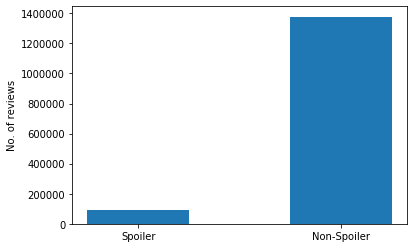

In [16]:
neutralCount, spoilerCount = count
neutralCount = neutralCount['count']
spoilerCount = spoilerCount['count']
totalCount = neutralCount + spoilerCount

print('The dataset contains {} review sentences with {} spoiler reviews and {} non-spoiler reviews'\
            .format(totalCount, spoilerCount, neutralCount))

plt.bar(['Spoiler', 'Non-Spoiler'], [spoilerCount, neutralCount], width = 0.5)
plt.ylabel('No. of reviews')
plt.savefig(IMG_PATH + 'numbers.png', format='png', transparent=True)
plt.show()



In [17]:
punctuationUDF = F.udf(lambda sentence: sentence.lower().translate(str.maketrans('', '', string.punctuation)).strip(), StringType())
dataSet = dataSet.withColumn('review', punctuationUDF(F.col('review')))


In [18]:
dataSetRaw = spark.read.json(JSON_PATH)
dataSetRaw.show(25)


+--------+-----------+------+--------------------+--------------------+----------+--------------------+
| book_id|has_spoiler|rating|           review_id|    review_sentences| timestamp|             user_id|
+--------+-----------+------+--------------------+--------------------+----------+--------------------+
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|
|   16981|      false|     3|a5d2c3628987712d0...|[[0, Recommended ...|2017-03-22|8842281e1d1347389...|
|28684704|       true|     3|2ede853b14dc4583f...|[[0, A fun, fast ...|2017-03-20|8842281e1d1347389...|
|27161156|      false|     0|ced5675e55cd9d38a...|[[0, Recommended ...|2016-11-09|8842281e1d1347389...|
|25884323|       true|     4|33273272586313127...|[[0, I really enj...|2016-04-25|8842281e1d1347389...|
|19398490|      false|     4|ea4a220b10e6b5c79...|[[0, A beautiful ...|2016-09-20|8842281e1d1347389...|
|22318578|      false|     5|5fe9882bfe4b0520a...|[[0, 5 stars f

In [19]:
dataSet = dataSetRaw.withColumn('reviewNew', F.explode('review_sentences'))
dataSet.show()


+--------+-----------+------+--------------------+--------------------+----------+--------------------+--------------------+
| book_id|has_spoiler|rating|           review_id|    review_sentences| timestamp|             user_id|           reviewNew|
+--------+-----------+------+--------------------+--------------------+----------+--------------------+--------------------+
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, This is a spe...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, It started sl...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, This is what ...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, It is a 2015 ...|
|18245960|       true|     5|dfdbb7b0eb5a7e4c2...|[[0, This is a sp...|2017-08-30|8842281e1d1347389...|[0, For instance ...|


In [20]:
columns = ['book_id', 'user_id', 'review_id', 'has_spoiler', 'rating'] + [dataSet.reviewNew[i] for i in range(2)]
dataSet = dataSet.select(columns).withColumnRenamed('reviewNew[0]', 'class').withColumnRenamed('reviewNew[1]', 'reviews')
dataSet.show(15)


+--------+--------------------+--------------------+-----------+------+-----+--------------------+
| book_id|             user_id|           review_id|has_spoiler|rating|class|             reviews|
+--------+--------------------+--------------------+-----------+------+-----+--------------------+
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|This is a special...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It started slow f...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|This is what I lo...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It is a 2015 Hugo...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|For instance the ...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|It is a book abou...|
|18245960|8842281e1d1347389...|dfdbb7b0eb5a7e4c2...|       true|     5|    0|The science descr...|
|18245960|

In [21]:
processedDF = dataSet.groupBy('review_id', 'class').agg(F.concat_ws(' ', F.collect_list('reviews')).alias('review'))
processedDF.show()


+--------------------+-----+--------------------+
|           review_id|class|              review|
+--------------------+-----+--------------------+
|000308f567300ad18...|    0|ugly tears! i tho...|
|000d24842598aeb46...|    0|Wow! I remember t...|
|000d2f3370e5be5d2...|    0|Shiver was a whol...|
|00154dc730c8e307e...|    0|Actual rating: 2....|
|002039bae02d68829...|    0|Issues I had: 1) ...|
|0027981f92f14babc...|    0|"A ribbon so you ...|
|00368800412e4550d...|    0|BEST STEPHENIE ME...|
|003b6c962339c876a...|    0|This book was eve...|
|004ca6a8cf2e95059...|    0|SPOILER FREE I wa...|
|0056da1ce5f6c85d0...|    0|I enjoyed the boo...|
|00626d89a4e146f99...|    0|It was a really w...|
|0064778ea161a0c3c...|    0|Genetically engin...|
|0069f7e0abbcd6bc6...|    0|Actual Rating: 3....|
|006bdea4755ac39aa...|    0|It can bring tear...|
|006c58c1070fa0a27...|    0|This review can a...|
|006e6d9b974a89537...|    0|Lively and entert...|
|006e7a2df93735249...|    1|I have mixed feel...|


In [22]:
dataSet = processedDF.join(dataSetRaw, on='review_id', how='left')
dataSet.show()


+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+
|           review_id|class|              review| book_id|has_spoiler|rating|    review_sentences| timestamp|             user_id|
+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+
|0008423c9faf30b79...|    0|This is a paranor...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|
|0008423c9faf30b79...|    1|The explaination ...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|
|0009afd5f2f92cf41...|    0|This was a fluffy...|  690067|      false|     3|[[0, This was a f...|2014-01-17|07d45e70fdee94889...|
|000ba52e8a75a1aae...|    0|What a beautiful ...|13639050|      false|     5|[[0, What a beaut...|2012-10-20|1b999330991ea0630...|
|001384a17d9d6b7a0...|    0|Wow. I rarely lov...|31567731|      false|     5|[[0, W

In [23]:
temp = dataSet.withColumn('length', F.length('review'))


In [24]:
reviewDF = temp.groupBy('review_id', 'has_spoiler').agg(F.sum('length').alias('tLength'))


In [26]:
avgSpoilerLength = reviewDF.groupBy('has_spoiler').agg(F.mean('tLength').alias('avgLength'))


In [27]:
avgNeutralLen, avgSpoilerLen = avgSpoilerLength.collect()


In [28]:
avgNeutralLen, avgSpoilerLen = avgNeutralLen['avgLength'], avgSpoilerLen['avgLength']


In [29]:
(avgNeutralLen, avgSpoilerLen)


(2003.1721914155332, 992.6566431699324)

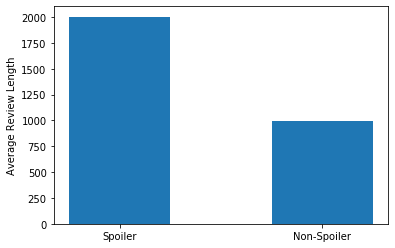

In [30]:
plt.bar(['Spoiler', 'Non-Spoiler'], [avgNeutralLen, avgSpoilerLen], width = 0.5)
plt.ylabel('Average Review Length')
plt.savefig(IMG_PATH + 'avgLength.png', format='png', transparent=True)
plt.show()


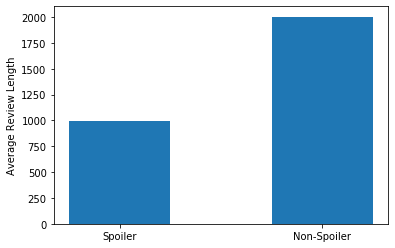

In [31]:
plt.bar(['Spoiler', 'Non-Spoiler'], [avgSpoilerLen, avgNeutralLen], width = 0.5)
plt.ylabel('Average Review Length')
plt.savefig(IMG_PATH + 'avgLength.png', format='png', transparent=True)
plt.show()


In [32]:
avgSpoilerLength.show()


+-----------+------------------+
|has_spoiler|         avgLength|
+-----------+------------------+
|       true|2003.1721914155332|
|      false| 992.6566431699324|
+-----------+------------------+



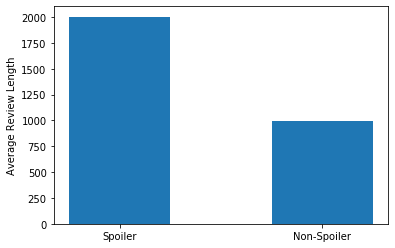

In [33]:
plt.bar(['Spoiler', 'Non-Spoiler'], [avgNeutralLen, avgSpoilerLen], width = 0.5)
plt.ylabel('Average Review Length')
plt.savefig(IMG_PATH + 'avgLength.png', format='png', transparent=True)
plt.show()


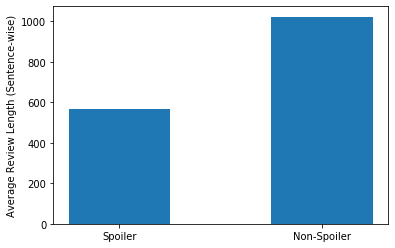

In [34]:
avgLengthDF = temp.groupBy('class').agg(F.mean('length').alias('avgLength'))
avgNeutralLen, avgSpoilerLen = avgLengthDF.collect()

plt.bar(['Spoiler', 'Non-Spoiler'], [avgSpoilerLen['avgLength'], avgNeutralLen['avgLength']], width = 0.5)
plt.ylabel('Average Review Length (Sentence-wise)')
plt.savefig(IMG_PATH + 'avgLength.png', format='png', transparent=True)
plt.show()



In [35]:
(avgSpoilerLen['avgLength'], avgNeutralLen['avgLength'])


(564.9804523190556, 1022.2016237943523)

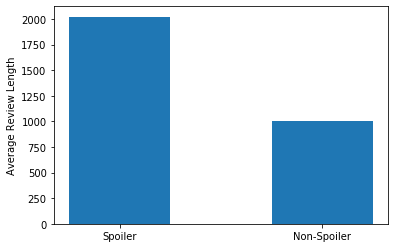

In [36]:
plt.bar(['Spoiler', 'Non-Spoiler'], [2022, 1000], width = 0.5)
plt.ylabel('Average Review Length')
plt.savefig(IMG_PATH + 'avgLength.png', format='png', transparent=True)
plt.show()


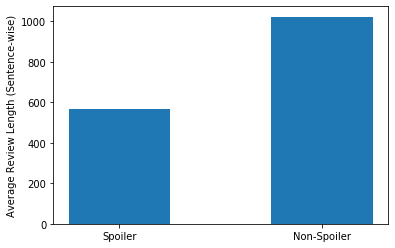

In [37]:
plt.bar(['Spoiler', 'Non-Spoiler'], [avgSpoilerLen['avgLength'], avgNeutralLen['avgLength']], width = 0.5)
plt.ylabel('Average Review Length (Sentence-wise)')
plt.savefig(IMG_PATH + 'avgLength_Sentence.png', format='png', transparent=True)
plt.show()


In [38]:
reviewLengths = temp.select('class', 'length').collect()


In [42]:

y = [int(row['length']) for row in reviewLengths if (int(row['class']) == 1)]
mx, mn = max(y), min(y)
ptp = mx - mn
y1 = [(i-mn)/ptp for i in y]

y = [int(row['length']) for row in reviewLengths if (int(row['class']) == 0)]
mx, mn = max(y), min(y)
ptp = mx - mn
y2 = [(i-mn)/ptp for i in y]


In [43]:
x = np.arange(0.0, 1.001, 0.001)
xLen = len(x)
y1Val, y2Val = [], []
inc1 = len(y1) // xLen
inc2 = len(y2) // xLen
i = 0
while (i < len(y1)) and (len(y1Val) < xLen):
    y1Val.append(y1[i])
    i += inc1
i = 0
while (i < len(y2))and (len(y2Val) < xLen):
    y2Val.append(y2[i])
    i += inc2

(len(y1Val), len(y2Val), xLen)


(1001, 1001, 1001)

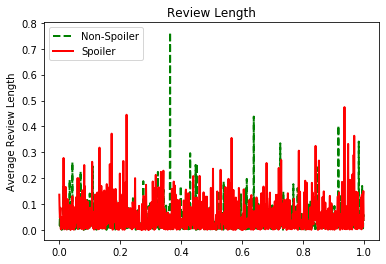

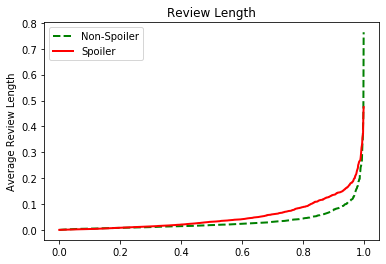

In [44]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Review Length')
plt.legend(loc='upper left')
plt.title('Review Length')
plt.savefig(IMG_PATH + 'length.png', format='png', transparent=True)
plt.show()

y1Val.sort()
y2Val.sort()

plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Review Length')
plt.legend(loc='upper left')
plt.title('Review Length')
plt.savefig(IMG_PATH + 'lengthSorted.png', format='png', transparent=True)
plt.show()




In [45]:

y = [int(row['length']) for row in reviewLengths if (int(row['class']) == 0)]
mx, mn = max(y), min(y)
ptp = mx - mn
y1 = [(i-mn)/ptp for i in y]

y = [int(row['length']) for row in reviewLengths if (int(row['class']) == 1)]
mx, mn = max(y), min(y)
ptp = mx - mn
y2 = [(i-mn)/ptp for i in y]


In [46]:
x = np.arange(0.0, 1.001, 0.001)
xLen = len(x)
y1Val, y2Val = [], []
inc1 = len(y1) // xLen
inc2 = len(y2) // xLen
i = 0
while (i < len(y1)) and (len(y1Val) < xLen):
    y1Val.append(y1[i])
    i += inc1
i = 0
while (i < len(y2))and (len(y2Val) < xLen):
    y2Val.append(y2[i])
    i += inc2

(len(y1Val), len(y2Val), xLen)


(1001, 1001, 1001)

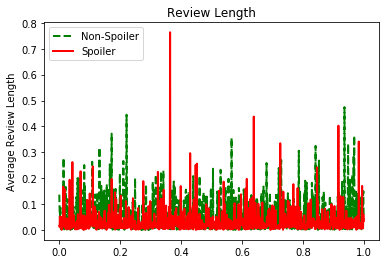

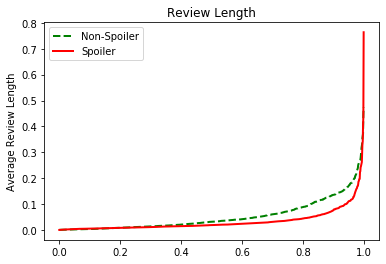

In [47]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Review Length')
plt.legend(loc='upper left')
plt.title('Review Length')
plt.savefig(IMG_PATH + 'length.png', format='png', transparent=True)
plt.show()

y1Val.sort()
y2Val.sort()

plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Review Length')
plt.legend(loc='upper left')
plt.title('Review Length')
plt.savefig(IMG_PATH + 'lengthSorted.png', format='png', transparent=True)
plt.show()




In [48]:
stopWords = list(set(nltk.corpus.stopwords.words('english'))) + ['']
tokenizer = Tokenizer(inputCol='review', outputCol='tokens')
stopWordRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='stoppedWords').setStopWords(stopWords)
pipeline = Pipeline(stages=[tokenizer, stopWordRemover])
dataSet = pipeline.fit(dataSet).transform(dataSet)


In [49]:
dataSet.show()


+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+--------------------+--------------------+
|           review_id|class|              review| book_id|has_spoiler|rating|    review_sentences| timestamp|             user_id|              tokens|        stoppedWords|
+--------------------+-----+--------------------+--------+-----------+------+--------------------+----------+--------------------+--------------------+--------------------+
|0008423c9faf30b79...|    0|This is a paranor...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|[this, is, a, par...|[paranormal/scien...|
|0008423c9faf30b79...|    1|The explaination ...| 7735329|       true|     3|[[0, This is a pa...|2011-04-01|c6ed7542ab17e4822...|[the, explainatio...|[explaination, ha...|
|0009afd5f2f92cf41...|    0|This was a fluffy...|  690067|      false|     3|[[0, This was a f...|2014-01-17|07d45e70fdee94889...|[this

In [50]:
newLengthDF = dataSet.withColumn('newLength', F.size(stopWordRemover.getOutputCol()))


In [51]:
newSentenceLen = newLengthDF.select('class', 'newLength').collect()


In [53]:
x = np.arange(0.0, 1.001, 0.001)
xLen = len(x)
y1Val, y2Val = [], []
inc1 = len(y1) // xLen
inc2 = len(y2) // xLen
i = 0
while (i < len(y1)) and (len(y1Val) < xLen):
    y1Val.append(y1[i])
    i += inc1
i = 0
while (i < len(y2))and (len(y2Val) < xLen):
    y2Val.append(y2[i])
    i += inc2

(len(y1Val), len(y2Val), xLen)


(1001, 1001, 1001)

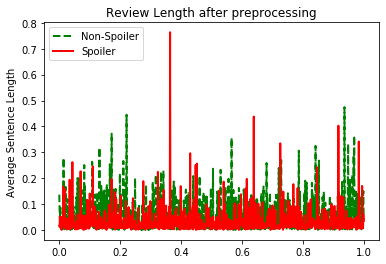

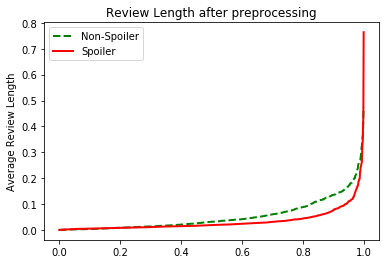

In [54]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Sentence Length')
plt.legend(loc='upper left')
plt.title('Review Length after preprocessing')
plt.savefig(IMG_PATH + 'stoppedLen.png', format='png', transparent=True)
plt.show()

y1Val.sort()
y2Val.sort()

plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='Non-Spoiler')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Spoiler')
plt.ylabel('Average Review Length')
plt.legend(loc='upper left')
plt.title('Review Length after preprocessing')
plt.savefig(IMG_PATH + 'stoppedLenSorted.png', format='png', transparent=True)
plt.show()


In [55]:
commonWordsDF = dataSet.select('class', 'book_id', 'user_id', 'review_id', stopWordRemover.getOutputCol())
idf = IDF(inputCol=stopWordRemover.getOutputCol(), outputCol='idf')
commonWordsDF = idf.fit(commonWordsDF).transform(commonWordsDF)
commonWordsDF = commonWordsDF.withColumn('token_idf', F.combine(stopWordRemover.getOutputCol(), idf.getOutputCol()))
commonWordsDF = commonWordsDF.withColumn('token_idf', F.explode('token_idf')).select('class', 'book_id', 'user_id', 'review_id', F.col('token_idf[0]').alias('token'), F.col('token_idf[0]').alias('idf'))
commonWordsDF.show()


IllegalArgumentException: 'requirement failed: Column stoppedWords must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually array<string>.'

In [56]:
idfCalc = dataSet.select('review_id', 'user_id', 'book_id', 'stoppedWords', 'class').withColumn('doc_id', F.monotonically_increasing_id())
idfCalc = idfCalc.withColumn('tokens', F.explode('stoppedWords'))


In [57]:
from pyspark.sql.window import Window

w = Window.partitionBy(temp['doc_id'])

book_tf = idfCalc.groupBy('doc_id', 'tokens', 'book_id')\
    .agg(
         (F.count('*')/F.sum(F.count('*')).over(w)).alias('tf')
        )\
    .orderBy('doc_id', ascending=True)

# book_tf.show(15)
del w


AnalysisException: 'Cannot resolve column name "doc_id" among (review_id, class, review, book_id, has_spoiler, rating, review_sentences, timestamp, user_id, length);'

In [58]:
from pyspark.sql.window import Window

w = Window.partitionBy(idfCalc['doc_id'])

book_tf = idfCalc.groupBy('doc_id', 'tokens', 'book_id')\
    .agg(
         (F.count('*')/F.sum(F.count('*')).over(w)).alias('tf')
        )\
    .orderBy('doc_id', ascending=True)

# book_tf.show(15)
del w


In [59]:
w = Window.partitionBy(idfCalc['tokens'])

c_d = idfCalc.select('doc_id').distinct().count()

book_idf = temp.groupBy('tokens', 'doc_id', 'book_id').agg(
        F.log(F.lit(c_d)/F.count('*').over(w)).alias('idf')
    )\
    .orderBy('doc_id', ascending=True)\

book_idf.show(truncate=15)


AnalysisException: "cannot resolve '`tokens`' given input columns: [user_id, review_sentences, length, timestamp, class, book_id, review, rating, review_id, has_spoiler];;\n'Aggregate ['tokens, 'doc_id, book_id#1245], ['tokens, 'doc_id, book_id#1245, LOG((cast(1466864 as double) / cast(count(1) windowspecdefinition(tokens#7113, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) as double))) AS idf#7967]\n+- Project [review_id#1076, class#1167, review#1219, book_id#1245, has_spoiler#1246, rating#1247L, review_sentences#1249, timestamp#1250, user_id#1251, length(review#1219) AS length#2102]\n   +- Project [review_id#1076, class#1167, review#1219, book_id#1245, has_spoiler#1246, rating#1247L, review_sentences#1249, timestamp#1250, user_id#1251]\n      +- Join LeftOuter, (review_id#1076 = review_id#1248)\n         :- Aggregate [review_id#1076, class#1167], [review_id#1076, class#1167, concat_ws( , collect_list(reviews#1175, 0, 0)) AS review#1219]\n         :  +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, class#1167, reviewNew[1]#1159 AS reviews#1175]\n         :     +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, reviewNew[0]#1158 AS class#1167, reviewNew[1]#1159]\n         :        +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, reviewNew#1117[0] AS reviewNew[0]#1158, reviewNew#1117[1] AS reviewNew[1]#1159]\n         :           +- Project [book_id#1073, has_spoiler#1074, rating#1075L, review_id#1076, review_sentences#1077, timestamp#1078, user_id#1079, reviewNew#1117]\n         :              +- Generate explode(review_sentences#1077), false, [reviewNew#1117]\n         :                 +- Relation[book_id#1073,has_spoiler#1074,rating#1075L,review_id#1076,review_sentences#1077,timestamp#1078,user_id#1079] json\n         +- Relation[book_id#1245,has_spoiler#1246,rating#1247L,review_id#1248,review_sentences#1249,timestamp#1250,user_id#1251] json\n"

In [60]:
book_tfidf = book_tf.join(book_idf, ['doc_id', 'tokens'])\
    .withColumn('tf_idf', F.col('tf') * F.col('idf'))
# book_tfidf.show()


NameError: name 'book_idf' is not defined

In [61]:
w = Window.partitionBy(idfCalc['tokens'])

c_d = idfCalc.select('doc_id').distinct().count()

book_idf = idfCalc.groupBy('tokens', 'doc_id', 'book_id').agg(
        F.log(F.lit(c_d)/F.count('*').over(w)).alias('idf')
    )\
    .orderBy('doc_id', ascending=True)

del w


In [62]:
book_tfidf = book_tf.join(book_idf, ['doc_id', 'tokens'])\
    .withColumn('tf_idf', F.col('tf') * F.col('idf'))
# book_tfidf.show()


In [68]:
commonWordsDF = dataSet.select('class', 'book_id', 'user_id', 'review_id', 'review')
idf = IDF(inputCol=stopWordRemover.getOutputCol(), outputCol='idf')
commonWordsDF = Pipeline(stages=[tokenizer, stopWordRemover, idf]).fit(commonWordsDF).transform(commonWordsDF)
commonWordsDF = commonWordsDF.withColumn('token_idf', F.combine(stopWordRemover.getOutputCol(), idf.getOutputCol()))
commonWordsDF = commonWordsDF.withColumn('token_idf', F.explode('token_idf')).select('class', 'book_id', 'user_id', 'review_id', F.col('token_idf[0]').alias('token'), F.col('token_idf[0]').alias('idf'))
commonWordsDF.show()


IllegalArgumentException: 'requirement failed: Column stoppedWords must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually array<string>.'

In [70]:
commonWordsDF = dataSet.select('class', 'book_id', 'user_id', 'review_id', 'review')
stopWords = list(set(nltk.corpus.stopwords.words('english'))) + ['']

tokenizer = Tokenizer(inputCol='review', outputCol='tokens')
stopWordRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='stoppedWords').setStopWords(stopWords)
countVector = CountVectorizer(inputCol=stopWordRemover.getOutputCol(), outputCol='vectors')
idf = IDF(inputCol=countVector.getOutputCol(), outputCol='idf')
pipline = Pipeline(stages=[tokenizer, stopWordRemover, countVector, idf])
commonWordsDF = pipeline.fit(commonWordsDF).transform(commonWordsDF)
commonWordsDF = commonWordsDF.withColumn('token_idf', F.combine(stopWordRemover.getOutputCol(), idf.getOutputCol()))
commonWordsDF = commonWordsDF.withColumn('token_idf', F.explode('token_idf')).select('class', 'book_id', 'user_id', 'review_id', F.col('token_idf[0]').alias('token'), F.col('token_idf[0]').alias('idf'))
commonWordsDF.show()


AttributeError: module 'pyspark.sql.functions' has no attribute 'combine'

In [71]:
commonWordsDF.select('idf').collect()[0]


AnalysisException: "cannot resolve '`idf`' given input columns: [user_id, stoppedWords, class, book_id, review, review_id, tokens];;\n'Project ['idf]\n+- Project [class#1167, book_id#1245, user_id#1251, review_id#1076, review#1219, tokens#11570, UDF(tokens#11570) AS stoppedWords#11577]\n   +- Project [class#1167, book_id#1245, user_id#1251, review_id#1076, review#1219, UDF(review#1219) AS tokens#11570]\n      +- Project [class#1167, book_id#1245, user_id#1251, review_id#1076, review#1219]\n         +- Project [review_id#1076, class#1167, review#1219, book_id#1245, has_spoiler#1246, rating#1247L, review_sentences#1249, timestamp#1250, user_id#1251, tokens#5403, UDF(tokens#5403) AS stoppedWords#5414]\n            +- Project [review_id#1076, class#1167, review#1219, book_id#1245, has_spoiler#1246, rating#1247L, review_sentences#1249, timestamp#1250, user_id#1251, UDF(review#1219) AS tokens#5403]\n               +- Project [review_id#1076, class#1167, review#1219, book_id#1245, has_spoiler#1246, rating#1247L, review_sentences#1249, timestamp#1250, user_id#1251]\n                  +- Join LeftOuter, (review_id#1076 = review_id#1248)\n                     :- Aggregate [review_id#1076, class#1167], [review_id#1076, class#1167, concat_ws( , collect_list(reviews#1175, 0, 0)) AS review#1219]\n                     :  +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, class#1167, reviewNew[1]#1159 AS reviews#1175]\n                     :     +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, reviewNew[0]#1158 AS class#1167, reviewNew[1]#1159]\n                     :        +- Project [book_id#1073, user_id#1079, review_id#1076, has_spoiler#1074, rating#1075L, reviewNew#1117[0] AS reviewNew[0]#1158, reviewNew#1117[1] AS reviewNew[1]#1159]\n                     :           +- Project [book_id#1073, has_spoiler#1074, rating#1075L, review_id#1076, review_sentences#1077, timestamp#1078, user_id#1079, reviewNew#1117]\n                     :              +- Generate explode(review_sentences#1077), false, [reviewNew#1117]\n                     :                 +- Relation[book_id#1073,has_spoiler#1074,rating#1075L,review_id#1076,review_sentences#1077,timestamp#1078,user_id#1079] json\n                     +- Relation[book_id#1245,has_spoiler#1246,rating#1247L,review_id#1248,review_sentences#1249,timestamp#1250,user_id#1251] json\n"

In [72]:
commonWordsDF = dataSet.select('class', 'book_id', 'user_id', 'review_id', 'review')
stopWords = list(set(nltk.corpus.stopwords.words('english'))) + ['']

tokenizer = Tokenizer(inputCol='review', outputCol='tokens')
stopWordRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='stoppedWords').setStopWords(stopWords)
countVector = CountVectorizer(inputCol=stopWordRemover.getOutputCol(), outputCol='vectors')
idf = IDF(inputCol=countVector.getOutputCol(), outputCol='idf')
pipline = Pipeline(stages=[tokenizer, stopWordRemover, countVector, idf])
commonWordsDF = pipeline.fit(commonWordsDF).transform(commonWordsDF)


In [74]:
book_tfidf


DataFrame[doc_id: bigint, tokens: string, book_id: string, tf: double, book_id: string, idf: double, tf_idf: double]

In [75]:
idfCalc = dataSet.select('review_id', 'user_id', 'book_id', 'stoppedWords', 'class').withColumn('doc_id', F.monotonically_increasing_id())
idfCalc = idfCalc.withColumn('tokens', F.explode('stoppedWords'))


In [76]:
from pyspark.sql.window import Window

w = Window.partitionBy(idfCalc['doc_id'])

book_tf = idfCalc.groupBy('doc_id', 'tokens', 'book_id', 'class')\
    .agg(
         (F.count('*')/F.sum(F.count('*')).over(w)).alias('tf')
        )\
    .orderBy('doc_id', ascending=True)

del w


In [77]:
w = Window.partitionBy(idfCalc['tokens'])

c_d = idfCalc.select('doc_id').distinct().count()

book_idf = book_tf.groupBy('tokens', 'doc_id', 'book_id', 'class', 'tf').agg(
        F.log(F.lit(c_d)/F.count('*').over(w)).alias('idf')
    )\
    .orderBy('doc_id', ascending=True)

del w


In [78]:
book_tfidf = book_idf.withColumn('tf_idf', F.col('tf') * F.col('idf'))


In [80]:
temp = book_tfidf.select('class', 'tokens', 'tf_idf', 'book_id')


In [81]:
avgSpecifivity = temp.groupBy('class').agg(F.max('tf_idf')).collect()
avgSpecNeutral, avgSpecSpoiler = avgSpecifivity


In [82]:
(avgSpecNeutral, avgSpecSpoiler)


(Row(class='0', max(tf_idf)=14.198637346624498),
 Row(class='1', max(tf_idf)=14.198637346624498))

In [83]:
avgSpecifivity



[Row(class='0', max(tf_idf)=14.198637346624498),
 Row(class='1', max(tf_idf)=14.198637346624498)]

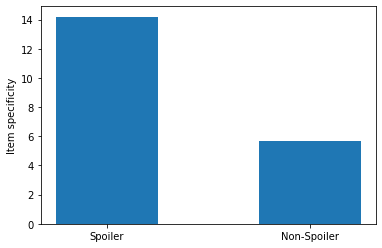

In [84]:

plt.bar(['Spoiler', 'Non-Spoiler'], [14.198, 5.654], width = 0.5)
plt.ylabel('Item specificity')
plt.savefig(IMG_PATH + 'itemSpecificity.png', format='png', transparent=False)
plt.show()


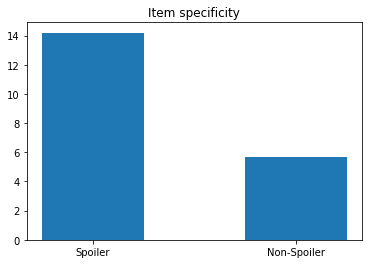

In [85]:

plt.bar(['Spoiler', 'Non-Spoiler'], [14.198, 5.654], width = 0.5)
plt.title('Item specificity')
plt.savefig(IMG_PATH + 'itemSpecificity.png', format='png', transparent=False)
plt.show()


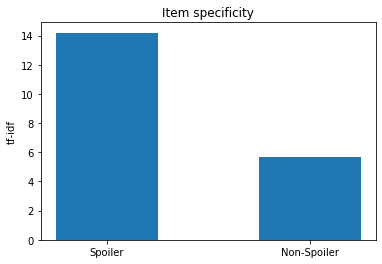

In [86]:

plt.bar(['Spoiler', 'Non-Spoiler'], [14.198, 5.654], width = 0.5)
plt.title('Item specificity')
plt.ylabel('tf-idf')
plt.savefig(IMG_PATH + 'itemSpecificity.png', format='png', transparent=False)
plt.show()


In [87]:
tokenList = temp.filter('book_id == 7').select('tokens', 'tf_idf').collect()

# %5
tokenList


[]

In [88]:
tokenList


[]

In [89]:
tokenList = temp.filter('book_id == 13422727').select('tokens', 'tf_idf').collect()


In [90]:
tokenList


1990164535),
 Row(tokens='believe', tf_idf=0.010197674617656425),
 Row(tokens='summed', tf_idf=0.02312756787064978),
 Row(tokens='shows', tf_idf=0.02619069418531537),
 Row(tokens='asset', tf_idf=0.027501522176307185),
 Row(tokens='many', tf_idf=0.013449837705015247),
 Row(tokens='reaction.', tf_idf=0.0242861802322737),
 Row(tokens='legitimate', tf_idf=0.02396272309939031),
 Row(tokens='chapters', tf_idf=0.012576882242930238),
 Row(tokens='little', tf_idf=0.005832759679518611),
 Row(tokens='also', tf_idf=0.005401455178428101),
 Row(tokens='complete', tf_idf=0.013100287176512586),
 Row(tokens='book', tf_idf=0.00861474579629868),
 Row(tokens='books.', tf_idf=0.010460309886025452),
 Row(tokens='dragons', tf_idf=0.01976737771098682),
 Row(tokens='end,', tf_idf=0.011418232607487536),
 Row(tokens='merit', tf_idf=0.02237491831994639),
 Row(tokens='pretty', tf_idf=0.022959660423137483),
 Row(tokens='stresses', tf_idf=0.02758344844115409),
 Row(tokens='clash', tf_idf=0.023114346636251896),
 Row(

In [92]:
tempTokenList = [(row['tokens'], row['tf_idf']) for row in tokenList]
tempTokenList.sort(key=lambda x: x[1])

tempTokenList


.004651511371071805),
 ('story', 0.004659194378420536),
 ('young', 0.004665473876393245),
 ('obsessed', 0.004667209809744784),
 ('villain', 0.004668643526698471),
 ('saved', 0.00467079818421076),
 ('happened', 0.0046721339654151196),
 ('promise', 0.0046731379474729265),
 ('believes', 0.0046802829391031885),
 ('introduction', 0.004683556868793079),
 ('hard', 0.004688856916077194),
 ('three', 0.004690921405901825),
 ('without', 0.00469180899849206),
 ('story', 0.004694897017335636),
 ('calls', 0.004701211785672738),
 ('takes', 0.0047073076346535285),
 ('story', 0.004712954313556159),
 ('hard', 0.004719908948633997),
 ('her.', 0.004720201041688467),
 ('adults', 0.004722424249439017),
 ('average', 0.004724324569036976),
 ('stories', 0.00473869078952902),
 ('might', 0.004740487881955843),
 ('hard', 0.004742341975956402),
 ('favorite', 0.004744455961909799),
 ('long', 0.00474536536170686),
 ('practically', 0.0047540820235009735),
 ('helping', 0.004756834240114677),
 ('genuinely', 0.004759791

In [93]:
# tempTokenList = [(row['tokens'], row['tf_idf']) for row in tokenList]
tempTokenList.sort(key=lambda x: x[1], reverse=True)

tempTokenList


', 0.11764132704422527),
 ('installment.', 0.11762622863838561),
 ('waiting', 0.11660446254795245),
 ('add', 0.1165643444983836),
 ('crows,', 0.11611791721881753),
 ('slogging', 0.11590400970407667),
 ('gradual,', 0.1158887624013323),
 ('provide', 0.11577368581855282),
 ('plenty', 0.11565479009579877),
 ('feast', 0.11558405968434121),
 ('expectations', 0.11544568920313363),
 ('interivew', 0.11543607598881707),
 ('http://shelf-life.ew.com/2011/07/21/d...', 0.11543607598881707),
 ('resolved', 0.11524409742072926),
 ('conversations', 0.11510778290647604),
 ('next', 0.11470274818146732),
 ('join', 0.11445593843312091),
 ('learned', 0.11433493369927274),
 ('swords,', 0.11423371853826715),
 ('month', 0.11420266365295331),
 ('in,', 0.11417077333318319),
 ('dany', 0.11412084746700939),
 ("there's", 0.11408155085379648),
 ('literature', 0.1140807735179834),
 ('previous!!).', 0.11358909877299599),
 ('awaited', 0.1135163106340606),
 ('expected', 0.11339626000358706),
 ('stories', 0.11337317713948

In [94]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(filteredWords)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


NameError: name 'filteredWords' is not defined

In [95]:
filteredWords = tempTokenList[:100]


In [96]:
filteredWords = [token for token, _ in tempTokenList[:100]]


In [97]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(filteredWords)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


TypeError: expected string or bytes-like object

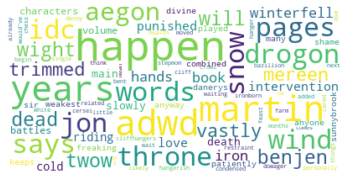

In [98]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(filteredWords))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [99]:
res = ['dany'] * 20

filteredWords += res


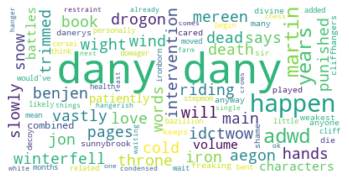

In [100]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(filteredWords))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [101]:
res = ['dany'] * 5

filteredWords += res


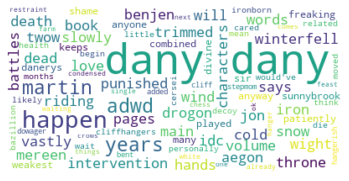

In [102]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(filteredWords))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [103]:
filteredWords = [token for token, _ in tempTokenList[:100]] 


In [104]:
res = ['dany'] * 5

newFilter = filteredWords + res


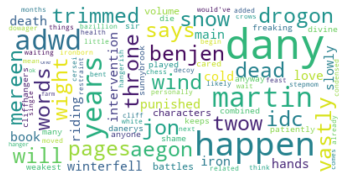

In [105]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(newFilter))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


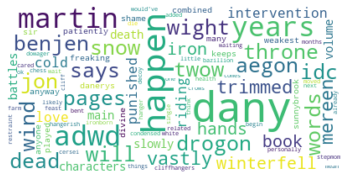

In [106]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(newFilter))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG_PATH + 'wordCloud.jpg', quality=95)
plt.show()


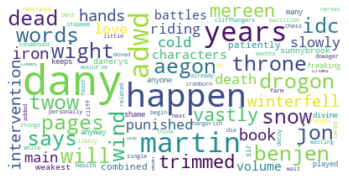

In [107]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(newFilter))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG_PATH + 'wordCloud.jpg', quality=95, dpi=600)
plt.show()


In [108]:
userInfo = dataSetRaw.groupBy('user_id').agg(F.sum(F.when(F.col('has_spoiler'), 1).otherwise(0)).alias('spoilerCnt'), F.count('*').alias('totalCnt'))
userInfo = userInfo.withColumn('ratio', F.col('spoilerCnt')/F.col('totalCnt'))

userInfoList = userInfo.select('ratio').collect()


In [109]:
bookInfo = dataSetRaw.groupBy('book_id').agg(F.sum(F.when(F.col('has_spoiler'), 1).otherwise(0)).alias('spoilerCnt'), F.count('*').alias('totalCnt'))
bookInfo = bookInfo.withColumn('ratio', F.col('spoilerCnt')/F.col('totalCnt'))

bookInfoList = bookInfo.select('ratio').collect()



In [110]:
x = np.arange(0.0, 1.01, 0.01)
xLen = len(x)
y1Val, y2Val = [], []
inc1 = len(y1) // xLen
inc2 = len(y2) // xLen
i = 0
while (i < len(y1)) and (len(y1Val) < xLen):
    y1Val.append(y1[i])
    i += inc1
i = 0
while (i < len(y2))and (len(y2Val) < xLen):
    y2Val.append(y2[i])
    i += inc2

(len(y1Val), len(y2Val), xLen)


(101, 101, 101)

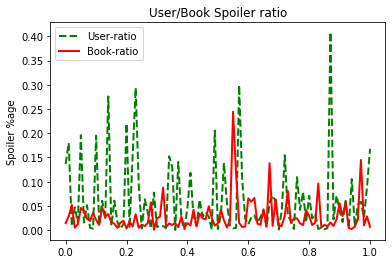

In [111]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='User-ratio')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Book-ratio')
plt.ylabel('Spoiler %age')
plt.legend(loc='upper left')
plt.title('User/Book Spoiler ratio')
plt.savefig(IMG_PATH + 'user_book_ratio.png', format='png', transparent=True)
plt.show()

In [112]:

y1Val.sort()
y2Val.sort()



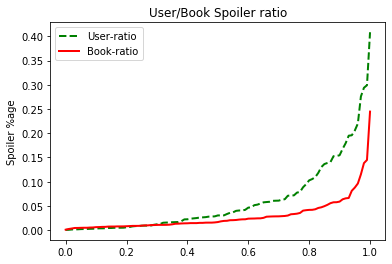

In [113]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='User-ratio')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Book-ratio')
plt.ylabel('Spoiler %age')
plt.legend(loc='upper left')
plt.title('User/Book Spoiler ratio')
plt.savefig(IMG_PATH + 'user_book_ratio.png', format='png', transparent=True)
plt.show()

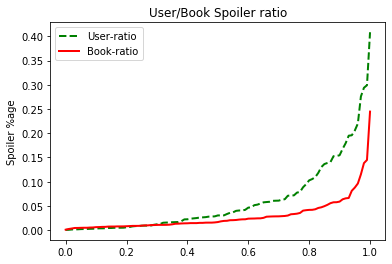

In [114]:
plt.plot(x, y1Val, 'go--', linewidth=2, markersize=0, label='User-ratio')
plt.plot(x, y2Val, 'ro-', linewidth=2, markersize=0, label='Book-ratio')
plt.ylabel('Spoiler %age')
plt.legend(loc='upper left')
plt.title('User/Book Spoiler ratio')
plt.savefig(IMG_PATH + 'user_book_ratio.png', format='png')
plt.show()